<a href="https://colab.research.google.com/github/jtayar/kiauhoku_stuff/blob/main/Clusterfest_model_offsets_RGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterfest RGB Model Offsets
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zclaytor/kiauhoku/blob/main/notebooks/model_offsets_RGB.ipynb)


This notebook serves as a demonstration on how to estimate the theoretical uncertainites due to model choice for stars along the red giant branch, as illustrated by Morales et al. (2025, accepted). This is the version tweaked by Jamie Tayar for Clusterfest.

**Contact:**
- Leslie Morales (l.morales@ufl.edu) for notebook information and the fitting routines used here
- Zach Claytor (zclaytor@stsci.edu) for general information regarding kīauhōkū
- Jamie Tayar (jtayar@ufl.edu) for information regarding the stellar model grids

**Resources:**
- kīauhōkū: https://github.com/zclaytor/kiauhoku
- models used in this notebook: https://zenodo.org/records/14908017

# Imports

We'll use the following packages:
- `warnings` to ignore some runtime warnings
- `numpy` for basic math utilities
- `matplotlib` for plotting
- `kiauhoku` for model grid interpolation and fitting

In [1]:
 %pip install kiauhoku==2.1.0

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import kiauhoku as kh

## 1. Load grids, unify column names, and cast to interpolators

In [3]:
# download grids if this is the first time running.
# The grids will automatically download even without this cell, but this
# lets us specify the right grid version numbers.
kh.download("yrec", kind="eep", version="2.1.2")
#kh.download("mist", kind="eep", version="2.1.2")
kh.download("dartmouth", kind="eep", version="2.1.2")
kh.download("garstec", kind="eep", version="2.1.2")

100%|██████████| 9.97M/9.97M [00:09<00:00, 1.16MB/s]
100%|██████████| 19.3M/19.3M [00:20<00:00, 1.00MB/s]
100%|██████████| 3.56M/3.56M [00:04<00:00, 905kB/s]


In [4]:
#kh.download("mist", kind="eep", version="2.1.2")
#note that the mist grid is too large to unpack in google colab.

In [5]:
qstring = '0.6 <= initial_mass <= 2 and -1.0 <= initial_met <= 0.5 and 201 <= eep <= 951'
qstringm = '0.6 <= initial_mass <= 2 and -1.0 <= initial_met <= 0.5 and 201 <= eep <= 605'

# Whether to fit evolved metallicity (True) or use the initial metallicity.
# False is probably fine if you're not on the giant branch.
evolve_met = False

yrec = kh.load_eep_grid("yrec").query(qstring)
# set column names to some standard
yrec['mass'] = yrec['Mass(Msun)']
yrec['teff'] = 10**yrec['Log Teff(K)']
yrec['lum'] = 10**yrec['L/Lsun']
if evolve_met:
    yrec['met'] = np.log10(yrec['Zsurf']/yrec['Xsurf']/0.0253)
else:
    yrec['met'] = yrec.index.get_level_values('initial_met')
yrec['age'] = yrec['Age(Gyr)']
# set name for readability of output
yrec.set_name('yrec')
# cast to interpolator
yrec = yrec.to_interpolator()

#mist = kh.load_eep_grid("mist").query(qstringm)
#mist['mass'] = mist['star_mass']
#mist['teff'] = 10**mist['log_Teff']
#mist['lum'] = 10**mist['log_L']
#if evolve_met:
#    mist['met'] = mist['log_surf_z'] - np.log10(mist['surface_h1']*0.0173)
#else:
#    mist['met'] = mist.index.get_level_values('initial_met')
#mist['logg'] = mist['log_g']
#mist['age'] = mist['star_age'] / 1e9
#mist.set_name('mist')
#mist = mist.to_interpolator()

dart = kh.load_eep_grid("dartmouth").query(qstring)
dart['mass'] = dart.index.to_frame()['initial_mass']
dart['teff'] = 10**dart['Log T']
dart['lum'] = 10**dart['Log L']
if evolve_met:
    dart['met'] = np.log10(dart['(Z/X)_surf']/0.0229)
else:
    dart['met'] = dart.index.get_level_values('initial_met')
dart['logg'] = dart['Log g']
dart['age'] = dart['Age (yrs)'] / 1e9
dart.set_name('dart')
dart = dart.to_interpolator()

gars = kh.load_eep_grid("garstec").query(qstring)
gars['mass'] = gars['M/Msun']
gars['teff'] = gars['Teff']
gars['lum'] = 10**gars['Log L/Lsun']
if evolve_met:
    gars['met'] = np.log10(gars['Zsurf']/gars['Xsurf']/0.0245)
else:
    gars['met'] = gars.index.get_level_values('initial_met')
gars['age'] = gars['Age(Myr)'] / 1e3
gars.set_name('gars')
gars = gars.to_interpolator()

## 2. Define a function to get information on your stars from the grids

In [6]:
def fit_all_grids(star, *args, **kwargs):
    gridnames = []
    models = []
    for gname, interp in zip(
        ['yrec',  'dartmouth', 'garstec'], #'mist',
        [yrec,  dart, gars]): #mist,
        model, fit = interp.gridsearch_fit(star, *args, **kwargs)
        if fit.success:
            gridnames.append(gname)
            models.append(
                model[['initial_mass', 'initial_met', 'eep', 'mass', 'teff', 'lum', 'met', 'logg', 'age']]
            )
    models = pd.concat(models, axis=1)
    models.columns = gridnames
    return models

def compute_statistics(models, exclude=None):
    stats = models.copy()
    if exclude is not None:
        stats = stats.drop(columns=exclude)

    mean = stats.mean(axis=1)
    stdev = stats.std(axis=1, ddof=1)
    max_offset = stats.max(axis=1) - stats.min(axis=1)

    stats['mean'] = mean
    stats['stdev'] = stdev
    stats['max offset'] = max_offset
    return stats


## 2.5 Check the Sun

Now that we have a model grid, let's check that the sun actually runs correctly. The scaling here deals with the problem that a step of 1 in Teff is small and a step of 1 in logg is huge.

In [7]:
sun1 = {'teff':5772, 'lum':1, 'met':0}
scale = {'teff':1000, 'lum':1, 'met':0.1}
models = fit_all_grids(sun1, scale=scale, tol=1e-6)
models

Fitting star with yrec...
yrec: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,dartmouth,garstec
initial_mass,9.637193e-01,9.963006e-01,9.964855e-01
initial_met,-3.554635e-09,6.093403e-09,-4.866653e-10
eep,3.615528e+02,3.368562e+02,3.391360e+02
mass,9.637193e-01,9.963006e-01,9.962164e-01
teff,5.772000e+03,5.772000e+03,5.772000e+03
lum,1.000000e+00,1.000000e+00,9.999999e-01
met,-3.554635e-09,6.093403e-09,-4.866653e-10
logg,4.430369e+00,4.435666e+00,4.436212e+00
age,7.336526e+00,4.813700e+00,4.800630e+00


In [8]:
stats = compute_statistics(models, exclude=None)
stats

,yrec,dartmouth,garstec,mean,stdev,max offset
initial_mass,9.637193e-01,9.963006e-01,9.964855e-01,9.855018e-01,1.886441e-02,3.276621e-02
initial_met,-3.554635e-09,6.093403e-09,-4.866653e-10,6.840342e-10,4.929408e-09,9.648039e-09
eep,3.615528e+02,3.368562e+02,3.391360e+02,3.458483e+02,1.364816e+01,2.469660e+01
mass,9.637193e-01,9.963006e-01,9.962164e-01,9.854121e-01,1.878654e-02,3.258124e-02
teff,5.772000e+03,5.772000e+03,5.772000e+03,5.772000e+03,7.270183e-05,1.394821e-04
lum,1.000000e+00,1.000000e+00,9.999999e-01,1.000000e+00,7.726719e-08,1.544346e-07
met,-3.554635e-09,6.093403e-09,-4.866653e-10,6.840342e-10,4.929408e-09,9.648039e-09
logg,4.430369e+00,4.435666e+00,4.436212e+00,4.434082e+00,3.227654e-03,5.843340e-03
age,7.336526e+00,4.813700e+00,4.800630e+00,5.650285e+00,1.460342e+00,2.535897e+00


Awkwardly, the sun is somewhere between 0.96 and 1.0 Msun. It also has an age between 4.8 and 7 Gyrs.

In [9]:
sun3 = {'age': 4.57, 'mass':1, 'met':0}
scale = {'age': 1, 'mass':0.1, 'met':0.1}
models = fit_all_grids(sun3, scale=scale, tol=1e-6)
models

Fitting star with yrec...
yrec: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,dartmouth,garstec
initial_mass,1.000000e+00,1.000000e+00,1.000263e+00
initial_met,1.868403e-08,3.078826e-08,-4.830295e-08
eep,3.237810e+02,3.312283e+02,3.343031e+02
mass,1.000000e+00,1.000000e+00,9.999999e-01
teff,5.843289e+03,5.780963e+03,5.780795e+03
lum,1.002368e+00,1.001356e+00,1.002201e+00
met,1.868403e-08,3.078826e-08,-4.830295e-08
logg,4.456824e+00,4.438753e+00,4.438384e+00
age,4.570000e+00,4.570002e+00,4.570000e+00


In [10]:
stats = compute_statistics(models, exclude=None)
stats

,yrec,dartmouth,garstec,mean,stdev,max offset
initial_mass,1.000000e+00,1.000000e+00,1.000263e+00,1.000088e+00,1.517719e-04,2.629055e-04
initial_met,1.868403e-08,3.078826e-08,-4.830295e-08,3.897781e-10,4.260123e-08,7.909122e-08
eep,3.237810e+02,3.312283e+02,3.343031e+02,3.297708e+02,5.410376e+00,1.052217e+01
mass,1.000000e+00,1.000000e+00,9.999999e-01,1.000000e+00,5.892722e-08,1.178463e-07
teff,5.843289e+03,5.780963e+03,5.780795e+03,5.801682e+03,3.603248e+01,6.249392e+01
lum,1.002368e+00,1.001356e+00,1.002201e+00,1.001975e+00,5.428043e-04,1.012491e-03
met,1.868403e-08,3.078826e-08,-4.830295e-08,3.897781e-10,4.260123e-08,7.909122e-08
logg,4.456824e+00,4.438753e+00,4.438384e+00,4.444654e+00,1.054179e-02,1.844038e-02
age,4.570000e+00,4.570002e+00,4.570000e+00,4.570001e+00,1.285542e-06,2.265812e-06


## 3. Load the sample of stars from the APOKASC-3 catalog

*Note*: The full catalog can be found here: https://zenodo.org/records/13308665

In [11]:
columns = [
    "KEPLER_ID","APOKASC3_MASS", "APOKASC3_MASS_ERR", "APOKASC3_RADIUS", "APOKASC3_RADIUS_ERR", "APOKASC3_LOGG",
    "APOKASC3_LOGG_ERR", "APOKASC3_TEFF", "APOKASC3_TEFF_ERR", "APOKASC3_LOGG_SPEC",
    "APOKASC3_LOGG_SPEC_ERR", "APOKASC3_M_H", "APOKASC3_M_H_ERR", "APOKASC3_ALPHA_M",
    "APOKASC3_ALPHA_M_ERR", "APOKASC3_CAT_AGE", "APOKASC3_AGE_RGB", "APOKASC3_AGE_RGB_PERR",
    "APOKASC3_AGE_RGB_MERR", "GAIA_TEFF", "GAIA_RADIUS", "GAIA_LUMINOSITY"
]

stars = [
    [10001440, 0.9482, 0.0365, 8.5217, 0.1475, 2.5553, 0.0042, 4750.2197, 52.0059, 2.4996, 0.058, -0.6552, 0.058, 0.3028, 0.022, "RGB", 10.0665, 1.5825, -1.2631, 4977.75, 7.628748, 32.190933],
    [10003349, 1.3773, 0.0531, 9.8369, 0.1705, 2.5931, 0.004, 4671.34, 46.7252, 2.6277, 0.058, -0.0492, 0.058, 0.0279, 0.022, "RGB", 3.7948, 0.4298, -0.3323, 4694.6104, 10.917146, 52.15682],
    [10003497, 1.1867, 0.0458, 12.1523, 0.2108, 2.3408, 0.0038, 4615.7476, 42.5666, 2.4042, 0.058, -0.1903, 0.058, 0.0743, 0.022, "RGB", 5.6234, 0.683, -0.5678, 4720.2524, 10.944278, 53.571007],
    [10004825, 1.688, 0.0651, 10.0175, 0.1737, 2.6656, 0.0041, 4653.666, 47.6694, 2.7126, 0.058, 0.181, 0.058, 0.0257, 0.022, "RGB", 2.2867, 0.2219, -0.1879, 4806.7476, 9.497579, 43.383617],
    [10006097, 1.099, 0.0422, 5.1385, 0.0889, 3.0591, 0.0041, 4795.506, 49.7726, 3.0803, 0.058, -0.0276, 0.058, 0.0554, 0.022, "RGB", 8.1643, 1.1403, -0.9563, 5004.34, 4.5984993, 11.94852]
]

star_data = pd.DataFrame(stars, columns=columns)
star_data

,KEPLER_ID,APOKASC3_MASS,APOKASC3_MASS_ERR,APOKASC3_RADIUS,APOKASC3_RADIUS_ERR,APOKASC3_LOGG,APOKASC3_LOGG_ERR,APOKASC3_TEFF,APOKASC3_TEFF_ERR,APOKASC3_LOGG_SPEC,...,APOKASC3_M_H_ERR,APOKASC3_ALPHA_M,APOKASC3_ALPHA_M_ERR,APOKASC3_CAT_AGE,APOKASC3_AGE_RGB,APOKASC3_AGE_RGB_PERR,APOKASC3_AGE_RGB_MERR,GAIA_TEFF,GAIA_RADIUS,GAIA_LUMINOSITY
0,10001440,0.9482,0.0365,8.5217,0.1475,2.5553,0.0042,4750.2197,52.0059,2.4996,...,0.058,0.3028,0.022,RGB,10.0665,1.5825,-1.2631,4977.7500,7.628748,32.190933
1,10003349,1.3773,0.0531,9.8369,0.1705,2.5931,0.0040,4671.3400,46.7252,2.6277,...,0.058,0.0279,0.022,RGB,3.7948,0.4298,-0.3323,4694.6104,10.917146,52.156820
2,10003497,1.1867,0.0458,12.1523,0.2108,2.3408,0.0038,4615.7476,42.5666,2.4042,...,0.058,0.0743,0.022,RGB,5.6234,0.6830,-0.5678,4720.2524,10.944278,53.571007
3,10004825,1.6880,0.0651,10.0175,0.1737,2.6656,0.0041,4653.6660,47.6694,2.7126,...,0.058,0.0257,0.022,RGB,2.2867,0.2219,-0.1879,4806.7476,9.497579,43.383617
4,10006097,1.0990,0.0422,5.1385,0.0889,3.0591,0.0041,4795.5060,49.7726,3.0803,...,0.058,0.0554,0.022,RGB,8.1643,1.1403,-0.9563,5004.3400,4.598499,11.948520


### 3a. Apply corrections and grab columns

In [12]:
# Apply Salaris correction
# All methods will use this metallicity
met_corr = star_data['APOKASC3_M_H'] + np.log10(0.638*(10**star_data['APOKASC3_ALPHA_M']) + 0.362)

#Asteroseismic params
mass = star_data['APOKASC3_MASS']
logg = star_data['APOKASC3_LOGG']

#Spectroscopic params
logg_spec = star_data['APOKASC3_LOGG_SPEC']
teff = star_data['APOKASC3_TEFF']

#Photometric params
lum = star_data['GAIA_LUMINOSITY']
teff_gaia = star_data['GAIA_TEFF']

## 4. Fit models to data

Using the first star from the list

### 4a. Using asteroseismic parameters

In [13]:
params = {'mass':mass[0], 'met':met_corr[0], 'logg':logg[0]}
scale = {'mass':1, 'met':1, 'logg':1}

models_0a = fit_all_grids(params, scale=scale, tol=1e-6)
models_0a

Fitting star with yrec...
yrec: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,dartmouth,garstec
initial_mass,0.948200,0.948200,0.952378
initial_met,-0.439507,-0.439508,-0.439507
eep,536.214382,537.241686,538.022890
mass,0.948200,0.948200,0.948200
teff,4746.247098,4772.317168,4800.954767
lum,32.979299,33.797783,34.603376
met,-0.439507,-0.439508,-0.439507
logg,2.555300,2.555300,2.555300
age,11.020415,10.377776,10.655091


### 4b. Using spectroscopic parameters

In [14]:
params = {'logg':logg_spec[0], 'met':met_corr[0], 'teff':teff[0]}
scale = {'logg':1, 'met':1, 'teff':1000}

models_0b = fit_all_grids(params, scale=scale, tol=1e-6)
models_0b

Fitting star with yrec...
yrec: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,dartmouth,garstec
initial_mass,1.087384,0.960728,0.825653
initial_met,-0.439507,-0.439506,-0.439507
eep,547.877061,542.295411,540.032750
mass,1.087384,0.960728,0.823693
teff,4750.219625,4750.219649,4750.219686
lum,43.282075,38.207954,32.707748
met,-0.439507,-0.439506,-0.439507
logg,2.499600,2.499600,2.499600
age,6.622056,9.935382,17.509895


### 4c. Using photometric parameters

In [15]:
params = {'lum':lum[0], 'met':met_corr[0], 'teff':teff_gaia[0]}
scale = {'lum':1, 'met':1, 'teff':1000}

models_0c = fit_all_grids(params, scale=scale, tol=1e-6)
models_0c

Fitting star with yrec...
yrec: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,dartmouth,garstec
initial_mass,1.432455,1.410077,1.315563
initial_met,-0.439506,-0.439507,-0.439505
eep,534.659327,535.113953,533.614379
mass,1.432455,1.410077,1.312964
teff,4977.749516,4977.750764,4977.753588
lum,32.190934,32.190937,32.190936
met,-0.439506,-0.439507,-0.439505
logg,2.827398,2.820470,2.789535
age,2.551568,2.656588,3.366406


### 4d. Compute the ind the max fractional offset between the model grids.

In [16]:
# What is the offset for the case with known mass?
offset_0a = (max(models_0a.loc['age']) - min(models_0a.loc['age'])) / max(models_0a.loc['age']) * 100
print(f"Fractional offset between model grids: {offset_0a:0.1f}%")

Fractional offset between model grids: 5.8%


In [17]:
# What is the offset for the cases WITHOUT known mass?
offset_0b = (max(models_0b.loc['age']) - min(models_0b.loc['age'])) / max(models_0b.loc['age']) * 100
offset_0c = (max(models_0c.loc['age']) - min(models_0c.loc['age'])) / max(models_0c.loc['age']) * 100
print(f"Fractional offset between model grids: \nUsing spectroscopic surface gravity and effective temperature: {offset_0b:0.1f}%")
print(f"Using GAIA luminosity and effective temperature: {offset_0c:0.1f}%")

Fractional offset between model grids: 
Using spectroscopic surface gravity and effective temperature: 62.2%
Using GAIA luminosity and effective temperature: 24.2%


## 5. Fit models to data

Using the last star on the list

### 5a. Using asteroseismic parameters

In [18]:
params = {'mass':mass[4], 'met':met_corr[4], 'logg':logg[4]}
scale = {'mass':1, 'met':1, 'logg':1}

models_4a = fit_all_grids(params, scale=scale, tol=1e-6)
models_4a

Fitting star with yrec...
yrec: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,dartmouth,garstec
initial_mass,1.099000,1.099000,1.102668
initial_met,0.008551,0.008552,0.008552
eep,508.171288,508.022459,508.724402
mass,1.099000,1.099000,1.098999
teff,4794.495673,4760.795715,4833.679272
lum,12.479922,12.132920,12.895813
met,0.008551,0.008552,0.008552
logg,3.059101,3.059099,3.059099
age,8.546140,8.498299,8.377169


### 5b. Using spectroscopic parameters

In [19]:
params = {'logg':logg_spec[4], 'met':met_corr[4], 'teff':teff[4]}
scale = {'logg':1, 'met':1, 'teff':1000}

models_4b = fit_all_grids(params, scale=scale, tol=1e-6)
models_4b

Fitting star with yrec...
yrec: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,dartmouth,garstec
initial_mass,1.078176,1.219308,0.975323
initial_met,0.008551,0.008552,0.008551
eep,507.181658,509.401628,505.452407
mass,1.078176,1.219308,0.974236
teff,4795.505511,4795.505885,4795.505529
lum,11.661859,13.205011,10.548507
met,0.008551,0.008552,0.008551
logg,3.080300,3.080301,3.080300
age,9.308736,5.739877,13.196649


### 5c. Using photometric parameters

In [20]:
params = {'lum':lum[4], 'met':met_corr[4], 'teff':teff_gaia[4]}
scale = {'lum':1, 'met':1, 'teff':1000}

models_4c = fit_all_grids(params, scale=scale, tol=1e-6)
models_4c

Fitting star with yrec...
yrec: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,dartmouth,garstec
initial_mass,1.541948,1.597015,1.457219
initial_met,0.008566,0.008548,0.008548
eep,508.097000,507.919849,508.498221
mass,1.541948,1.597015,1.456044
teff,5004.336694,5004.356839,5004.330778
lum,11.948532,11.948505,11.948524
met,0.008566,0.008548,0.008548
logg,3.299231,3.314796,3.274611
age,2.564146,2.320210,3.093843


### 5d. Compute the ind the max fractional offset between the model grids.

In [21]:
# What is the offset for the case with known mass?
offset_4a = (max(models_4a.loc['age']) - min(models_4a.loc['age'])) / max(models_4a.loc['age']) * 100
print(f"Fractional offset between model grids: {offset_4a:0.1f}%")

Fractional offset between model grids: 2.0%


In [22]:
# What is the offset for the cases WITHOUT known mass?
offset_4b = (max(models_4b.loc['age']) - min(models_4b.loc['age'])) / max(models_4b.loc['age']) * 100
offset_4c = (max(models_4c.loc['age']) - min(models_4c.loc['age'])) / max(models_4c.loc['age']) * 100
print(f"Fractional offset between model grids: \nUsing spectroscopic surface gravity and effective temperature: {offset_4b:0.1f}%")
print(f"Using GAIA luminosity and effective temperature: {offset_4c:0.1f}%")

Fractional offset between model grids: 
Using spectroscopic surface gravity and effective temperature: 56.5%
Using GAIA luminosity and effective temperature: 25.0%


## 6. Plots

Let's plot some tracks to check the interpolation of the first star on the list for the cases without known mass. We want to ensure that the grid estimated mass aligns with the model tracks.

Grid estimated mass (Msun): 
yrec         1.087384
dartmouth    0.960728
garstec      0.823693
Name: mass, dtype: float64


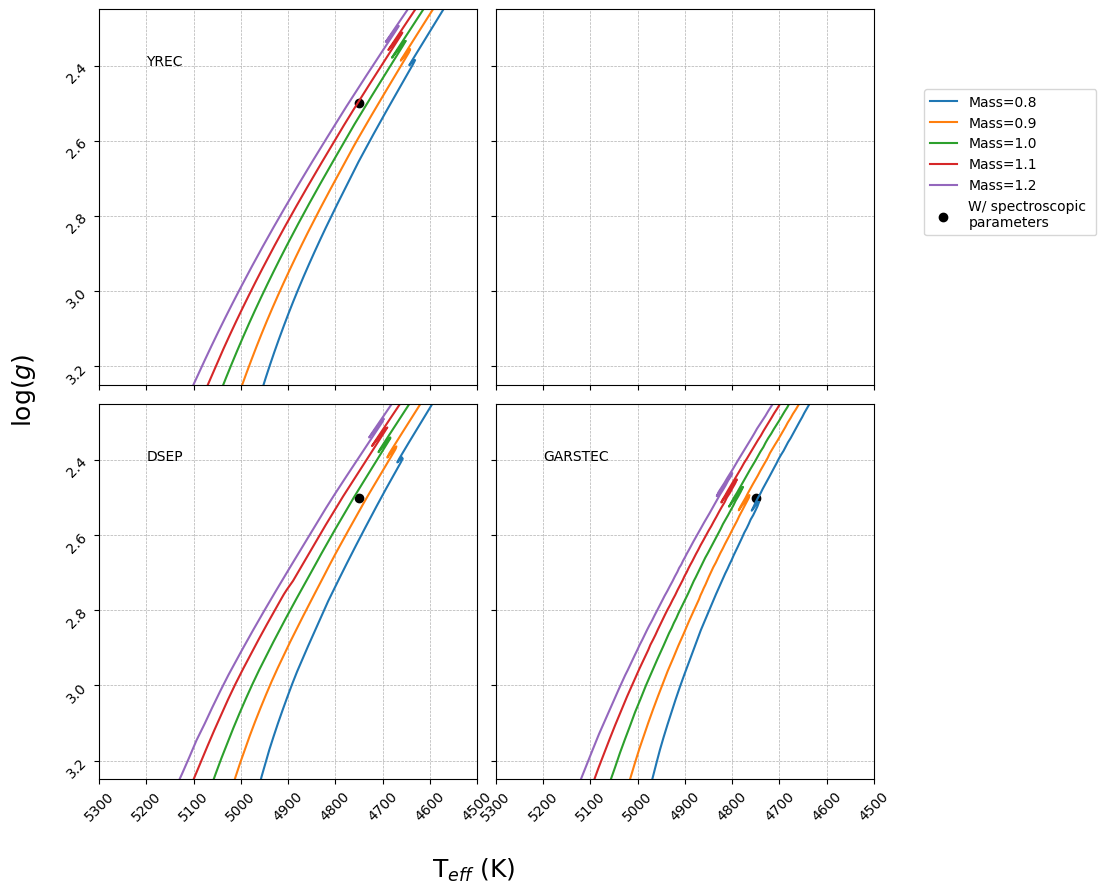

In [23]:
def get_tracks(model, masses, metallicity=0.0):
    return [model.get_track((mass, metallicity)) for mass in masses]

models = {"YREC": yrec,  "DSEP": dart, "GARS": gars} #"MIST": mist,
masses = [0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6]
metallicity = met_corr[0]

yrec_tracks = get_tracks(yrec, masses, metallicity=metallicity)
#mist_tracks = get_tracks(mist, masses, metallicity=metallicity)
dart_tracks = get_tracks(dart, masses, metallicity=metallicity)
gars_tracks = get_tracks(gars, masses, metallicity=metallicity)


fig,arr = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
for mass, track in zip(masses[0:5], yrec_tracks[0:5]):
    arr[0, 0].plot(track['teff'], track['logg'], label=f"Mass={mass:.1f}")
#for mass, track in zip(masses[0:5], mist_tracks[0:5]):
#    arr[0, 1].plot(track['teff'], track['logg'])
for mass, track in zip(masses[0:5], dart_tracks[0:5]):
    arr[1, 0].plot(track['teff'], track['logg'])
for mass, track in zip(masses[0:5], gars_tracks[0:5]):
    arr[1, 1].plot(track['teff'], track['logg'])

arr[0, 0].annotate('YREC',xy=(5200,2.4),xytext=(5200,2.4),size='medium')
#arr[0, 1].annotate('MIST',xy=(5200,2.4),xytext=(5200,2.4),size='medium')
arr[1, 0].annotate('DSEP',xy=(5200,2.4),xytext=(5200,2.4),size='medium')
arr[1, 1].annotate('GARSTEC',xy=(5200,2.4),xytext=(5200,2.4),size='medium')

arr[0,0].invert_xaxis()
arr[0,0].set_ylim(3.25,2.25)
arr[0,0].set_xlim(5300,4500)

for i in range(2):
    for j in range(2):
        arr[i, j].grid(True, which='both', linestyle='--', linewidth=0.5)
        arr[i, j].tick_params(axis='x', rotation=45)
        arr[i, j].tick_params(axis='y', rotation=45)
        arr[i, j].tick_params(axis='both', labelsize=10)

#plot the star
arr[0,0].scatter(models_0b['yrec'].loc['teff'],models_0b['yrec'].loc['logg'],c='k',label='W/ spectroscopic \nparameters')
#arr[0,1].scatter(models_0b['mist'].loc['teff'],models_0b['mist'].loc['logg'],c='k')
arr[1,0].scatter(models_0b['dartmouth'].loc['teff'],models_0b['dartmouth'].loc['logg'],c='k')
arr[1,1].scatter(models_0b['garstec'].loc['teff'],models_0b['garstec'].loc['logg'],c='k')

fig.text(0.05, 0.5, r'$\log(g)$', ha='center', va='center', rotation='vertical',size=18)
fig.text(0.5, 0.02, r'T$_{eff}$ (K)', ha='center', va='center',size=18)
fig.legend(bbox_to_anchor=(0.95, 0.8), loc='upper left', borderaxespad=0.)
plt.subplots_adjust(hspace=0.05,wspace=0.05);
print(f"Grid estimated mass (Msun): \n{models_0b.loc['mass']}")

Now, let's check the interpolation using photometric parameters.

Grid estimated mass (Msun): 
yrec         1.432455
dartmouth    1.410077
garstec      1.312964
Name: mass, dtype: float64


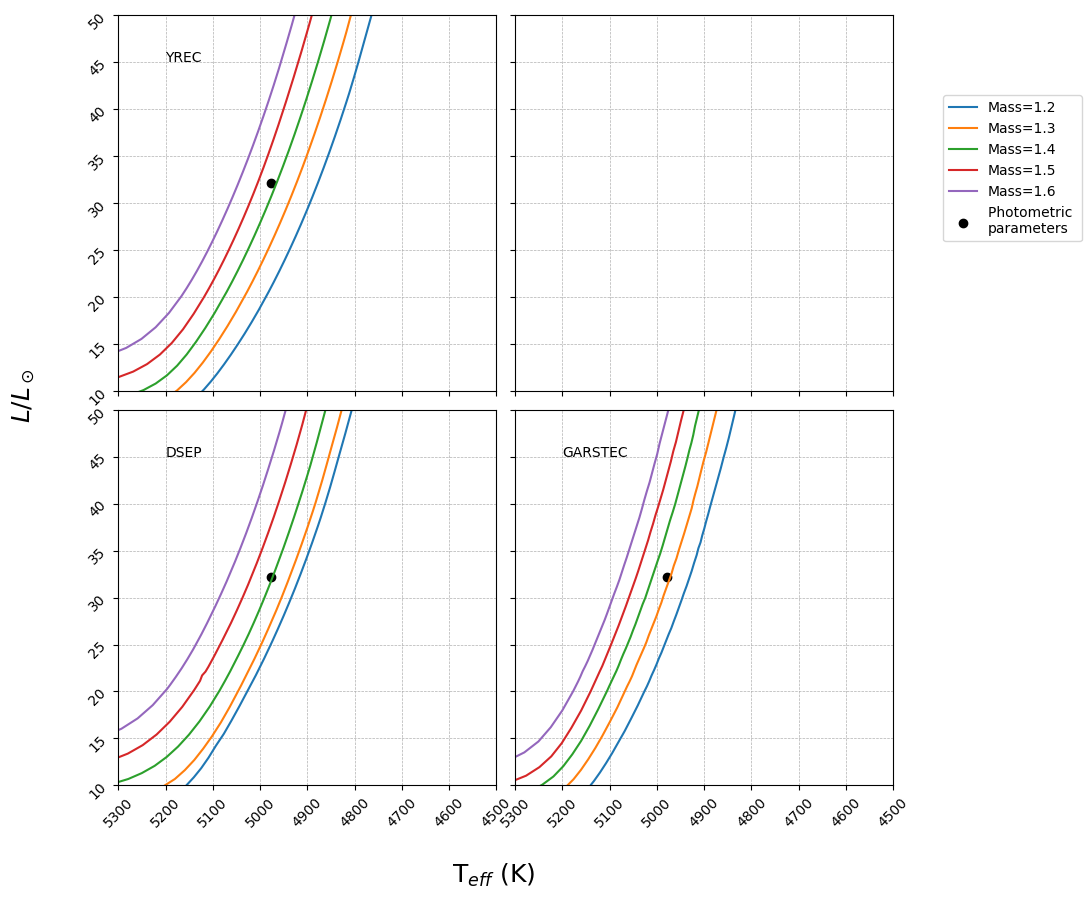

In [24]:
fig,arr = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
for mass, track in zip(masses[4:9], yrec_tracks[4:9]):
    arr[0, 0].plot(track['teff'], track['lum'], label=f"Mass={mass:.1f}")
#for mass, track in zip(masses[4:9], mist_tracks[4:9]):
#    arr[0, 1].plot(track['teff'], track['lum'])
for mass, track in zip(masses[4:9], dart_tracks[4:9]):
    arr[1, 0].plot(track['teff'], track['lum'])
for mass, track in zip(masses[4:9], gars_tracks[4:9]):
    arr[1, 1].plot(track['teff'], track['lum'])

arr[0, 0].annotate('YREC',xy=(5200,45),xytext=(5200,45),size='medium')
#arr[0, 1].annotate('MIST',xy=(5200,45),xytext=(5200,45),size='medium')
arr[1, 0].annotate('DSEP',xy=(5200,45),xytext=(5200,45),size='medium')
arr[1, 1].annotate('GARSTEC',xy=(5200,45),xytext=(5200,45),size='medium')

arr[0,0].invert_xaxis()
arr[0,0].set_ylim(10,50)
arr[0,0].set_xlim(5300,4500)

for i in range(2):
    for j in range(2):
        arr[i, j].grid(True, which='both', linestyle='--', linewidth=0.5)
        arr[i, j].tick_params(axis='x', rotation=45)
        arr[i, j].tick_params(axis='y', rotation=45)
        arr[i, j].tick_params(axis='both', labelsize=10)


arr[0,0].scatter(models_0c['yrec'].loc['teff'],models_0c['yrec'].loc['lum'],c='k',label='Photometric \nparameters')
#arr[0,1].scatter(models_0c['mist'].loc['teff'],models_0c['mist'].loc['lum'],c='k')
arr[1,0].scatter(models_0c['dartmouth'].loc['teff'],models_0c['dartmouth'].loc['lum'],c='k')
arr[1,1].scatter(models_0c['garstec'].loc['teff'],models_0c['garstec'].loc['lum'],c='k')

fig.text(0.03, 0.5, r'$L/L_\odot$', ha='center', va='center', rotation='vertical',size=18)
fig.text(0.5, 0.02, r'T$_{eff}$ (K)', ha='center', va='center',size=18)
fig.legend(bbox_to_anchor=(0.95, 0.8), loc='upper left', borderaxespad=0.)
plt.subplots_adjust(hspace=0.05,wspace=0.05);
print(f"Grid estimated mass (Msun): \n{models_0c.loc['mass']}")

## 7. Summary

Good news is that our interpolation process works! :D

Bad news is that we are left with a hefty offset in age between grids when mass is unknown. :(